This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray powered Cf/Radial and ODIM_H5

In this example, we read and write Cf/Radial (NetCDF) and ODIM_H5 (HDF5) data files from different sources using an xarray powered data structure.

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io.xarray import CfRadial, OdimH5

## Load ODIM_H5 Volume Data

In [2]:
fpath = 'hdf5/2019090101000500dBZ.vol.h5'
f = wrl.util.get_wradlib_data_file(fpath)
cf1 = OdimH5(f, standard='cf', mask_and_scale=False, georef=True, dim0="azimuth")

### Inspect root group

You can use the object dictionary using cf1['root'] or the `property` cf1.root.

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [3]:
cf1.root

<xarray.Dataset>
Dimensions:              (sweep: 11)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2019-09-01T01:00:05Z'
    time_coverage_end    <U20 '2019-09-01T01:04:21Z'
    latitude             float64 51.19
    longitude            float64 3.064
    altitude             float64 50.0
    altitude_agl         float64 nan
    sweep_group_name     (sweep) <U8 'sweep_1' 'sweep_2' ... 'sweep_11'
    sweep_fixed_angle    (sweep) float64 0.3 0.9 1.5 2.2 ... 6.5 9.0 13.0 25.0
    frequency            float64 nan
    status_xml           <U4 'None'
Attributes:
    Conventions:          Cf/Radial
    version:              H5rad 2.0
    title:                None
    institution:          WMO:06410,RAD:BX42,PLC:Jabbeke,NOD:bejab,CTY:605,CM...
    references:           None
    source:               None
    hi

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [4]:
cf1['sweep_1']

<xarray.Dataset>
Dimensions:       (azimuth: 360, range: 598)
Coordinates:
    sweep_mode    <U20 ...
    latitude      float64 ...
    altitude      float64 ...
    longitude     float64 ...
    elevation     (azimuth) float32 ...
  * azimuth       (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range         (range) float32 250.0 750.0 1250.0 ... 298250.0 298750.0
    y             (azimuth, range) float32 ...
    z             (azimuth, range) float32 ...
    gr            (azimuth, range) float32 ...
    rays          (azimuth, range) float32 ...
    bins          (azimuth, range) float32 ...
    x             (azimuth, range) float32 ...
    time          (azimuth) datetime64[ns] ...
Data variables:
    DBZH          (azimuth, range) uint8 ...
    sweep_number  int64 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    fixed_angle   float64 ...

In [5]:
sweep = cf1['sweep_1']
sweep = sweep.isel(azimuth=slice(345,355))
sweep = sweep.isel(range=slice(40,50))
print(sweep)
varname = "TH"
varname = "DBZH"
var = sweep[varname]
print(var.values)

<xarray.Dataset>
Dimensions:       (azimuth: 10, range: 10)
Coordinates:
    sweep_mode    <U20 ...
    latitude      float64 ...
    altitude      float64 ...
    longitude     float64 ...
    elevation     (azimuth) float32 ...
  * azimuth       (azimuth) float32 345.5 346.5 347.5 ... 352.5 353.5 354.5
  * range         (range) float32 20250.0 20750.0 21250.0 ... 24250.0 24750.0
    y             (azimuth, range) float32 ...
    z             (azimuth, range) float32 ...
    gr            (azimuth, range) float32 ...
    rays          (azimuth, range) float32 ...
    bins          (azimuth, range) float32 ...
    x             (azimuth, range) float32 ...
    time          (azimuth) datetime64[ns] ...
Data variables:
    DBZH          (azimuth, range) uint8 ...
    sweep_number  int64 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    fixed_angle   float64 ...
[[ 65  57  53  57  63  80  57  60  61  55]
 [ 62  53  57  55  67  81  51  56  57  54]
 [ 59  58  65  63 155 175  84 

### Plotting

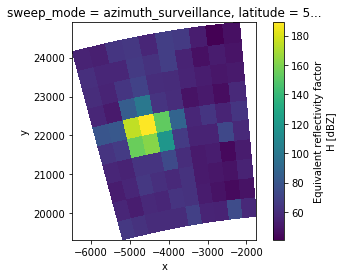

In [6]:
var.plot.pcolormesh(x='x', y='y')
pl.gca().set_aspect('equal')

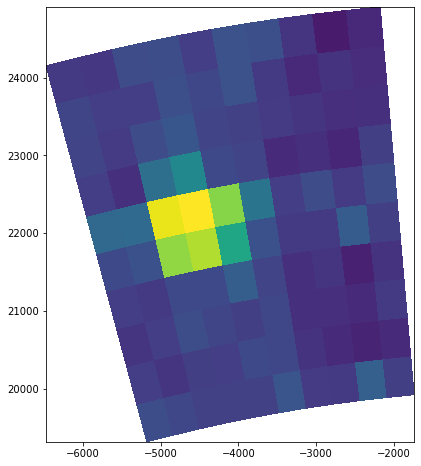

In [7]:
fig = pl.figure(figsize=(10,8))
var.wradlib.plot_ppi(fig=fig, vmin=30, vmax=180)

In [8]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                                      central_longitude=cf1['sweep_1'].longitude.values)

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7f447eca88f0> >


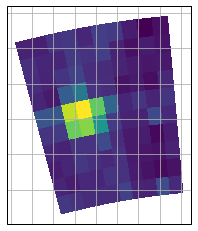

In [9]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                                      central_longitude=cf1['sweep_1'].longitude.values)
pm = var.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

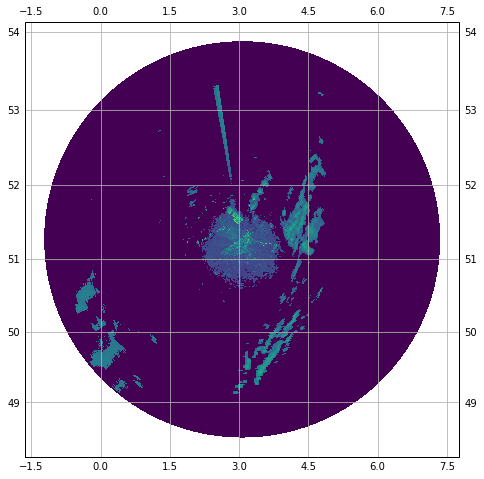

In [10]:
map_proj = ccrs.Mercator(central_longitude=cf1['sweep_1'].longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = cf1['sweep_1'].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

NameError: name 'DBZH' is not defined

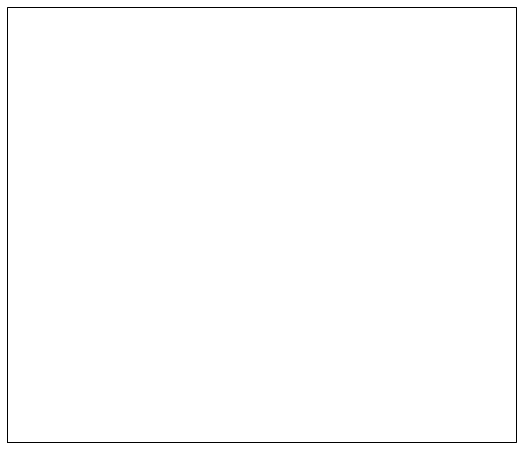

In [11]:
import cartopy.feature as cfeature
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='physical',
                                           name='coastline',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=2, zorder=4)

map_proj = ccrs.Mercator(central_longitude=cf1['sweep_1'].longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)

pm = var.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

In [ ]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                                     central_longitude=cf1['sweep_1'].longitude.values,
                                    )
pm = var.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)


In [ ]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                               central_longitude=cf1['sweep_1'].longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = var.wradlib.plot_ppi(ax=ax)
ax.gridlines()

In [ ]:
var.wradlib.plot_ppi()

### Inspect radar moments

The dataarrays can be accessed by key or by attribute. Each dataarray has the datasets dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [ ]:
var

In [ ]:
cf1['sweep_1']

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('azimuth')` method, which sorts the radials by azimuth.

In [ ]:
cf1['sweep_1'].sortby('azimuth')[varname].plot(add_labels=False)

In [ ]:
pm = var.wradlib.plot_ppi(proj={'latmin': 33e3})

In [ ]:
cf1.to_odim('knmi_odim.h5')
cf1.to_cfradial2('knmi_odim_as_cfradial.nc')

### Import again

In [ ]:
cf1a = OdimH5('knmi_odim.h5', standard='cf', georef=True)
cf1b = CfRadial('knmi_odim_as_cfradial.nc', dim0='azimuth', georef=True)

In [ ]:
cf1a['sweep_1']

### Check equality

In [ ]:
xr.testing.assert_equal(cf1.root, cf1a.root)
xr.testing.assert_equal(cf1['sweep_1'], cf1a['sweep_1'])
xr.testing.assert_equal(cf1.root, cf1b.root)
xr.testing.assert_equal(cf1['sweep_1'], cf1b['sweep_1'])

### Mask some values

In [ ]:
cf1['sweep_1']['DBZH'] = cf1['sweep_1']['DBZH'].where(cf1['sweep_1']['DBZH'] >= 0)
cf1['sweep_1']['DBZH'].sortby('azimuth').plot()

## Load Cf/Radial1 Volume Data

In [ ]:
fpath = 'netcdf/cfrad.20080604_002217_000_SPOL_v36_SUR.nc'
f = wrl.util.get_wradlib_data_file(fpath)
cf2 = CfRadial(f, georef=True)

### Inspect root group

In [ ]:
cf2.root

### Inspect sweep group(s)

In [ ]:
cf2['sweep_1']

### Inspect radar moments

In [ ]:
cf2['sweep_1'].DBZ

### Create simple plot

In [ ]:
cf2['sweep_1'].DBZ.plot()

In [ ]:
cf2['sweep_1'].DBZ.plot.pcolormesh(x='x', y='y', add_labels=False)
pl.gca().set_aspect('equal')

### Use wradlib DataArray connector

In [ ]:
pm = cf2['sweep_1'].DBZ.wradlib.plot_ppi()

In [ ]:
pm = cf2['sweep_1'].DBZ.wradlib.plot_ppi(proj='cg')

### Export data to Cf/Radial2 and ODIM_H5

In [ ]:
cf2.to_cfradial2('timrex_cfradial2.nc')
cf2.to_odim('timrex_cfradial_as_odim.h5')

### Import again

In [ ]:
cf2a = CfRadial('timrex_cfradial2.nc', georef=True)
cf2b = OdimH5('timrex_cfradial_as_odim.h5', standard='cf', georef=True)

In [ ]:
cf2a['sweep_1'].DBZ.plot.pcolormesh(x='x', y='y', add_labels=False)
pl.gca().set_aspect('equal')

In [ ]:
cf2b['sweep_1'].DBZ.plot.pcolormesh(x='x', y='y', add_labels=False)
pl.gca().set_aspect('equal')

### Check equality

For Cf/Radial there are issues with nan, which need to be fixed. For the ODIM_H5 intercomparison there are too problems with nan and issues with attributes.

In [ ]:
xr.testing.assert_equal(cf2.root, cf2a.root)
xr.testing.assert_equal(cf2['sweep_1'].drop(['DBZ', 'VR']), 
                        cf2a['sweep_1'].drop(['DBZ', 'VR']))

xr.testing.assert_allclose(cf2.root.time_coverage_start, 
                           cf2b.root.time_coverage_start)